In [1]:
from __future__ import division
%matplotlib inline

In [2]:
import numpy as np
import qinfer as qi

In [3]:
from functools import partial

In [4]:
import matplotlib.style
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt

In [5]:
class CartesianPhaseEstimationModel(qi.Model):
    @property
    def n_modelparams(self): return 2
    @property
    def modelparam_names(self): return ["x", "y"]
    @property
    def is_n_outcomes_constant(self): return True
    @property
    def expparams_dtype(self): return [
        ('m', int), ('theta', float)
    ]
    
    def n_outcomes(self, expparams): return 2
    def are_models_valid(self, modelparams):
        return np.ones((modelparams.shape[0], ), dtype=bool)
    
    def likelihood(self, outcomes, modelparams, expparams):
        super(CartesianPhaseEstimationModel, self).likelihood(
            outcomes, modelparams, expparams
        )
        
        x, y = (modelparams.T)[..., None]
        m    = expparams[None, ...]['m']
        th   = expparams[None, ...]['theta']
        
        pr0 = np.zeros((modelparams.shape[0], expparams.shape[0]))
        
        pr0[:, :] = (1 + np.cos(m * (np.arctan2(y, x) - th))) / 2
        
        return qi.Model.pr0_to_likelihood_array(outcomes, pr0)
    
    def canonicalize(self, modelparams):
        return modelparams / np.linalg.norm(modelparams, 2, axis=1)[:, None]

In [6]:
class UnitCirclePrior(qi.Distribution):
    @property
    def n_rvs(self): return 2
    
    def sample(self, n=1):
        th = np.random.random((n,)) * 2 * np.pi
        return np.array([
            np.cos(th), np.sin(th)
        ]).T

In [7]:
PhaseEstimationPGH = partial(qi.PGH,
    inv_field='theta',
    inv_func=lambda x_: np.arctan2(x_[:, 1], x_[:, 0]),
    t_field='m', t_func=np.ceil,
    other_fields={'n_meas': 1}
)

In [8]:
prior = UnitCirclePrior()

In [9]:
model = qi.BinomialModel(CartesianPhaseEstimationModel())

In [10]:
true_phase = prior.sample()
updater = qi.smc.SMCUpdater(model, 1000, prior)
heuristic = PhaseEstimationPGH(updater)

In [11]:
for idx_experiment in xrange(20):
    experiment = heuristic()
    outcome = model.simulate_experiment(true_phase, experiment)
    updater.update(outcome, experiment)

In [12]:
np.arctan2(*reversed(updater.est_mean()))

-0.14765645348090708

In [13]:
np.arctan2(*reversed(true_phase[0]))

-0.14970710485802322

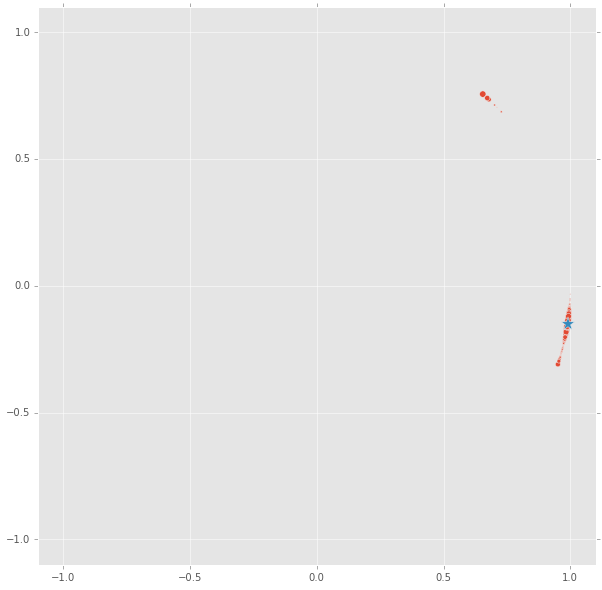

In [14]:
plt.figure(figsize=(10, 10))
plt.scatter(*updater.particle_locations.T,
    c=plt.rcParams['axes.color_cycle'][0],
    s=1000*np.sqrt(updater.particle_weights)
)
plt.scatter(true_phase[0, 0], true_phase[0, 1],
    c=plt.rcParams['axes.color_cycle'][1],
    marker='*',
    s=200
)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal')

In [15]:
particle_phases = np.arctan2(*reversed(updater.particle_locations.T))
true_phase_phase = np.arctan2(*reversed(true_phase.T))

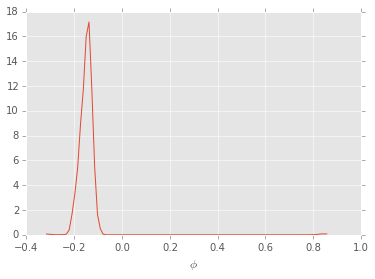

In [16]:
# This is a bloody awful hack to reuse updater.plot_posterior_marginal. Don't do this!
old_locs = updater.particle_locations
updater.particle_locations = particle_phases[:, None]
updater.plot_posterior_marginal(idx_param=0)
plt.xlabel(r'$\phi$')
updater.particle_locations = old_locs